# Description
This notebook aims to compare the models performance accross different segments

# Setup

In [1]:
import pandas as pd
import plotly.express as px
import re
import numpy as np
from IPython.display import Image
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
import joblib
import shap

import findspark
import pyspark
from pyspark.sql import SparkSession
import pyspark
from pyspark.sql import DataFrame
import pyspark.sql.functions as sql
from pyspark.sql.window import Window
from pyspark.sql.functions import *
from pyspark.sql import functions as F
from pyspark.sql.types import *
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler

from pyspark.ml import Pipeline, PipelineModel
from pyspark.ml.regression import GeneralizedLinearRegression
from pyspark.ml.functions import vector_to_array

from sklearn.base import BaseEstimator, ClassifierMixin

/home/neon/Documents/lending-club-analysis/lending-club-analysis/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
findspark.init()
sc = pyspark.SparkContext(appName="Test")
spark = SparkSession.builder.master("local[*]") \
                    .appName('test') \
                    .getOrCreate()

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
25/06/10 14:21:11 WARN Utils: Your hostname, pop-os-note, resolves to a loopback address: 127.0.0.1; using 192.168.0.4 instead (on interface wlp2s0)
25/06/10 14:21:11 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/06/10 14:21:17 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [58]:
spark.conf.set("spark.sql.execution.arrow.pyspark.enabled","true")
input_path = "../data/"
output_path = "../outputs/"

# Data

In [4]:
train_data = spark.read.parquet(f"{output_path}train_df_woe.parquet")
test_data  = spark.read.parquet(f"{output_path}test_df_woe.parquet") 

# Models

In [ ]:
class pysparkLogRegWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, pyspark_pipeline: PipelineModel):
        self.pipeline_model = pyspark_pipeline
        self.model = self.pipeline_model.stages[1]
        self.vectorizer = self.pipeline_model.stages[0]
        self.feature_name_ = self.vectorizer.getInputCols()
        self.feature_name_in_ = self.vectorizer.getInputCols()
        self.classes_ = np.array([0,1], dtype=int)
        self.params = self.model.params
        self.intercept_ = self.model.intercept
        self.coef_ = np.array(list(self.model.coefficients), dtype=float)
        self.predictionCol = self.model.getPredictionCol()
    
    def fit(self, x, y):
        pass

    def predict_proba(self, data):
        return self.predict(data)
    
    def predict(self, data):
        if isinstance(data, pd.DataFrame):
            data = data.to_numpy()
        result = 1/(1+np.exp(-1*((data * self.coef_).sum(axis=1) + self.intercept_)))
        # result = (data * self.coef_).sum(axis=1) + self.intercept_
        pred_2 = 1 - result
        return np.column_stack((pred_2, result))
    
    def predict2(self, data):
        if isinstance(data, DataFrame):
            df = data
        else:
            pd_df = pd.DataFrame(data).reset_index()
            df = spark.createDataFrame(pd_df, ['index'] + self.feature_name_)
        result = df\
            .transform(self.pipeline_model.transform)\
            .orderBy("index")\
            .select(collect_list(self.predictionCol))\
            .first()[0]
        result = np.array(result)
        pred_2 = 1 - result
        return np.column_stack((pred_2, result))
    
    def __sklearn_tags__(self):
        tags = super().__sklearn_tags__()
        tags.estimator_type = "classifier"
        return tags


class statsModelLogRegWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, log_reg):
        self.log_reg = log_reg
        self.feature_name_ = log_reg.params.index
        self.feature_names_in_ = log_reg.params.index
        self.classes_ = np.array([0,1], dtype=int)
        self.params = log_reg.params
        self.intercept_ = np.array(0, dtype=float)
        self.coef_ = list(self.params.values())
        self.coef_ = np.array(self.coef_, dtype=float)
    
    def fit(self, x, y):
        pass

    def predict_proba(self, data):
        pred_series = self.log_reg.predict(data)
        pred_series_2 = 1 - pred_series
        return np.column_stack((pred_series_2, pred_series))
    
    def predict(self, data):
        pred_series = self.log_reg.predict(data)
        pred_series_2 = 1 - pred_series
        return np.column_stack((pred_series_2, pred_series))
    
    def __sklearn_tags__(self):
        tags = super().__sklearn_tags__()
        tags.estimator_type = "classifier"
        return tags

log_reg = PipelineModel.load(f"{output_path}_log_reg.gz")

py_log_reg = pysparkLogRegWrapper(log_reg)

In [6]:
sk_log_reg = joblib.load(f"{output_path}sk_log_reg.gz")

In [ ]:
sk_log_reg.feature_names_in_

array(['funded_amnt_woe', 'term_woe', 'sub_grade_woe',
       'home_ownership_woe', 'annual_inc_woe', 'verification_status_woe',
       'zip_code_woe', 'dti_woe', 'earliest_cr_line_woe',
       'fico_range_low_woe', 'inq_last_6mths_woe', 'revol_util_woe'],
      dtype=object)

# Analysis

In [ ]:
selected_cols = \
['funded_amnt_woe',
 'term_woe',
 'sub_grade_woe',
 'home_ownership_woe',
 'annual_inc_woe',
 'verification_status_woe',
 'zip_code_woe',
 'dti_woe',
 'earliest_cr_line_woe',
 'fico_range_low_woe',
 'inq_last_6mths_woe',
 'revol_util_woe']

target_col = "default_flag"

train_pd = train_data.select(
    ["id"] +
    selected_cols + 
    [target_col]
)\
.toPandas()\
.sort_values("id")\
.reset_index(drop=True)

xtrain = train_pd.drop(["id", "default_flag"], axis="columns")

In [100]:
py_log_reg.predict_proba(xtrain)

array([[0.87760657, 0.12239343],
       [0.67457114, 0.32542886],
       [0.84654869, 0.15345131],
       ...,
       [0.83915473, 0.16084527],
       [0.93041089, 0.06958911],
       [0.9066316 , 0.0933684 ]], shape=(809048, 2))

In [97]:
sk_log_reg.predict_proba(xtrain)

array([[0.87760542, 0.12239458],
       [0.67457282, 0.32542718],
       [0.84654733, 0.15345267],
       ...,
       [0.83915103, 0.16084897],
       [0.93040739, 0.06959261],
       [0.90663285, 0.09336715]], shape=(809048, 2))

In [ ]:
explainer = shap.LinearExplainer(py_log_reg, xtrain)

In [11]:
shap_values = explainer(xtrain)

LinearExplainer explainer: 809049it [00:28, 18715.49it/s]                            


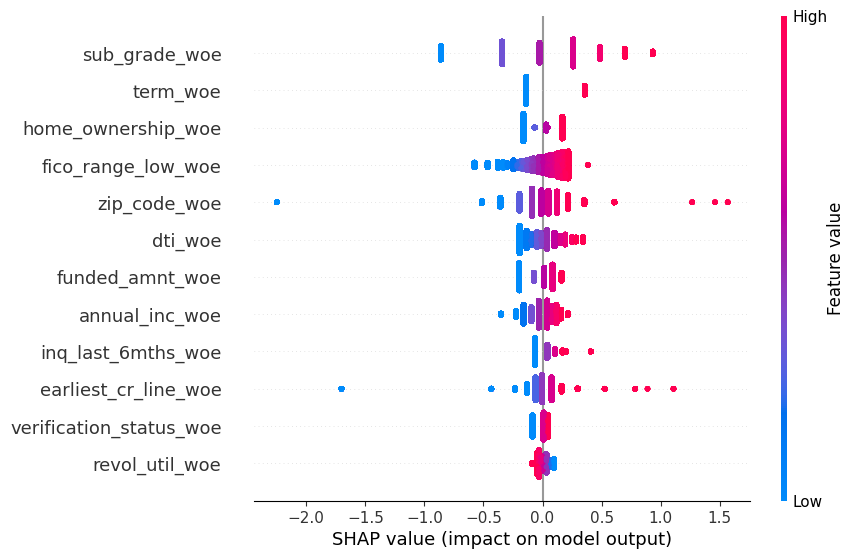

In [13]:
shap.plots.beeswarm(shap_values, max_display=20)

In [11]:
explainer = shap.Explainer(sk_log_reg, xtrain)
shap_values = explainer(xtrain)

LinearExplainer explainer: 809049it [00:28, 17101.04it/s]                            


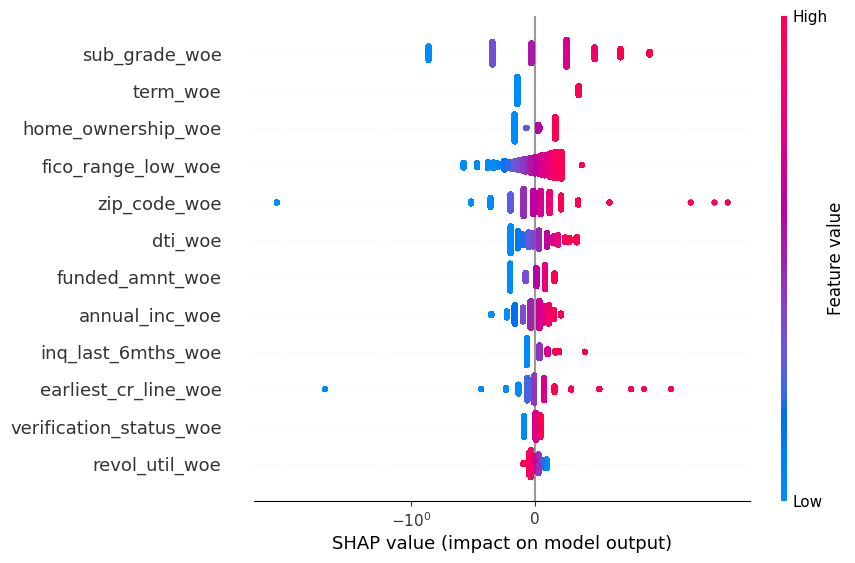

In [12]:
shap.plots.beeswarm(shap_values, max_display=20, log_scale=True)

In [39]:
xtrain = train_pd.sample(100).drop(["id","default_flag"], axis="columns")

explainer = shap.KernelExplainer(sk_log_reg.predict_proba, xtrain)
shap_values = explainer(xtrain)

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:26<00:00,  3.71it/s]


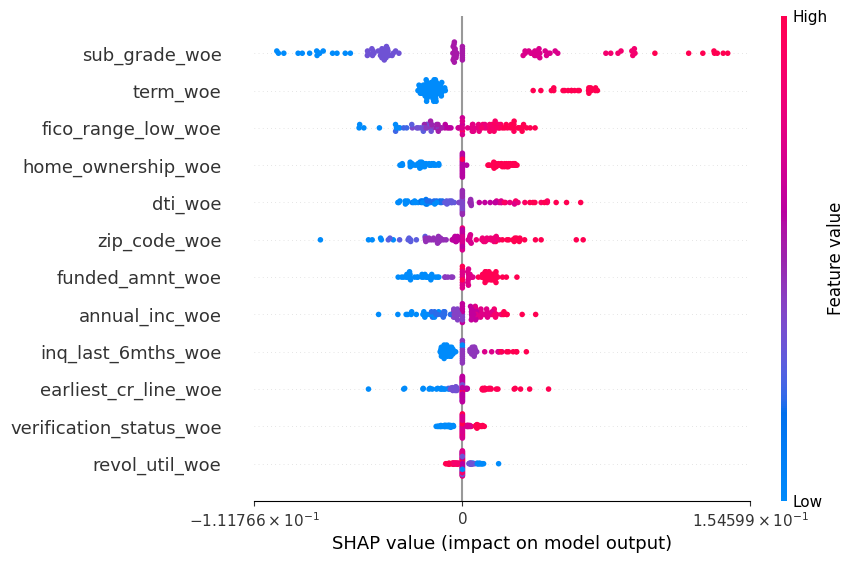

In [41]:
shap.plots.beeswarm(shap_values[:,:,1], max_display=20, log_scale=True)

In [105]:
xtrain = train_pd.sample(100).drop(["id","default_flag"], axis="columns")

explainer = shap.KernelExplainer(py_log_reg.predict, xtrain)
shap_values = explainer(xtrain)

100%|██████████| 100/100 [00:23<00:00,  4.21it/s]


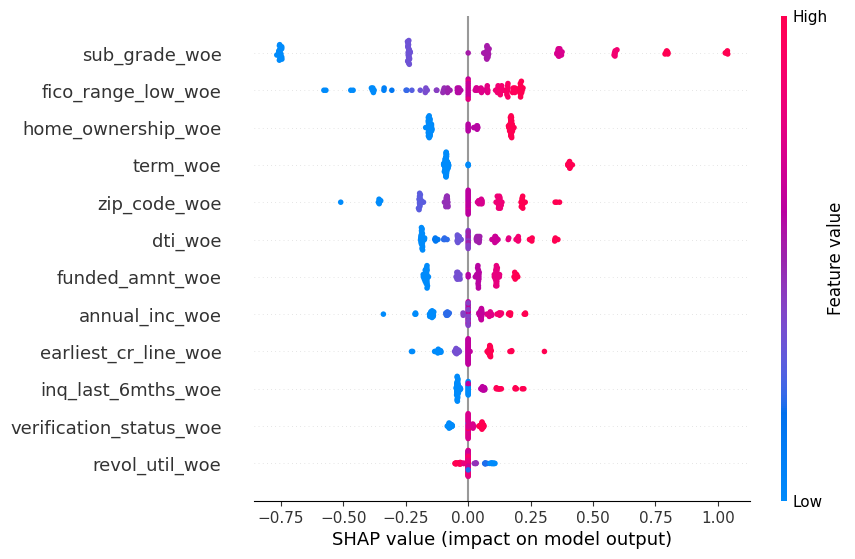

In [106]:
shap.plots.beeswarm(shap_values[:,:,1], max_display=20)

## SHAP

In [ ]:
class applyShap:
    def __init__(self,
                 model,
                 data):
        self.model = model
        self.data = data
    
    def explain(self):
        try:
            self.explainer = shap.TreeExplainer(self.model, feature_perturbation="tree_path_dependent")
        except:
            self.explainer = shap.LinearExplainer(self.mode, self.data, feature_names = self.model.features_names_in_)
        self.shap_values = self.explainer(self.data)
    
    def calculate_shap_values(self):
        self.shap_values = self.explainer(self.data)
    
    def beeswarm_plot(self, max_display=20, log_scale=False):
        try:
            shap.plots.beeswarm(self.shap_values, max_display = max_display, log_scale = log_scale)
        except:
            shap.plots.beeswarm(self.shap_values[:,:,1], max_display = max_display, log_scale = log_scale)